In [214]:
import utils
from utils import *
import importlib
import numpy as np
import math
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Conv2D, Reshape, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D
import time




In [256]:
def run_neural_network(X_train, y_train, X_test, y_test, subset_size=0.016):
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.016)
    #X_train, y_train, X_test, y_test = split_data(X_train, y_train, train_size=0.08)
    
    num_category = 10 

    y_train_oh = keras.utils.to_categorical(y_train, num_category)
    y_test_oh = keras.utils.to_categorical(y_test, num_category)

    model = keras.Sequential()
    print(X_train.shape)
    #model.add(Dense(32, input_dim=784))
    #model.add(Conv2D(32, [3, 3], activation='relu', input_shape=(X_train.shape[1],)))
    #model.add(Reshape((28, 28, 1), input_shape=(X_train.shape[1],)))
    #model.add(Conv2D(2, (2, 2), activation='relu', ))
    input_img = Input(shape=(784,))
    model.add(Dense(128, activation='relu')(input_img))
    model.add(Conv2D(4, (2, 2), activation='relu', input_shape=X_train.shape[1]))
    model.add(Conv2D(8, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Train and fit the model:
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train_oh, epochs=20, verbose=1, batch_size=32,  validation_split=.1)
    loss, accuracy  = model.evaluate(X_test, y_test_oh, verbose=False)
    print(history.history)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('VGG16 accuracy MNIST')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print('Test loss: ', loss)
    print('Test accuracy: ', accuracy)
    
    
def load_data(clean=False):
    print("loading data...")
    df_train = pd.read_csv("data/mnist/csv_format/train.csv")
    df_test = pd.read_csv("data/mnist/csv_format/test.csv")
    X = []
    y = []
    for row in df_train.iterrows() :
        label = row[1][0] # label (the number visible in the image)
        image = list(row[1][1:]) # image information as list, without label
        image = np.array(image)
        X.append(image)
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    if clean:
        X = StandardScaler().fit_transform(X)
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)

def k_means_elbow_viz(X, k_range=(2, 15)):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=k_range)
    visualizer.fit(X)
    visualizer.show()

def k_means_silhouette(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10]):

    times = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        start_time = time.time()

        cluster_labels = clusterer.fit_predict(X)
        end_time = time.time() - start_time
        times.append(end_time)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    plt.title('k means fit time per # clusters')
    plt.tight_layout()
    plt.show()
    
def k_means_silhouette_iloc(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10]):

    times = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        start_time = time.time()

        cluster_labels = clusterer.fit_predict(X)
        end_time = time.time() - start_time
        times.append(end_time)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    plt.title('k means fit time per # clusters')
    plt.tight_layout()
    plt.show()

def k_means_experiment(X_train, X_test, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    X_train_new = kmeans.fit_transform(X_train)
    X_test_new = kmeans.transform(X_test)
    return X_train_new, X_test_new
    
def gmm_experiment(X_train, X_test, comps):
    gmm = GMM(random_state=13, n_components=comps)
    X_train_new = gmm.fit_transform(X_train)
    X_test_new = gmm.transform(X_test)
    return X_train_new, X_test_new
    
    
def GMM_elbow(X, y, range_n_clusters=[1, 2, 3, 4, 5, 6]):
    aics = []
    bics = []
    scores = []
    times=[]
    for i in range_n_clusters:
        gmm = GMM(random_state=13, n_components=i)
        start_time = time.time()
        gmm.fit(X)
        end_time = time.time() - start_time
        times.append(end_time)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        scores.append(gmm.score(X, y))
    plt.plot(range_n_clusters, aics, label="AIC")
    plt.plot(range_n_clusters, bics, label="BIC")
    plt.xlabel ("n clusters")
    plt.ylabel ("AIC/BIC")
    plt.legend()
    plt.title ("AIC/BIC elbow method per n_clusters")
    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    plt.title('gmm fit time per # clusters')
    plt.tight_layout()
    plt.show()



def build_pc_col_names(num):
    col_vals = []
    for i in range(1, num+1):
        col_vals.append(i)
    return col_vals

def compare_comp_vals_PCA(X, y, vals_range=[1, 2, 3, 4, 5, 6, 7]):
    result_dfs = []
    times = []
    n_comp_vals = vals_range
    for comp_val in n_comp_vals:
        print("uh")
        pca = PCA(n_components=comp_val)
        col_vals = build_pc_col_names(comp_val)
        start_time = time.time()
        components = pca.fit_transform(X)
        end_time = time.time() - start_time
        times.append(end_time)
        pdf = pd.DataFrame(data = components
                     , columns = col_vals)
        pdy = pd.DataFrame(data=y, columns=["labels"])
        finalDf = pd.concat([pdf, pdy], axis = 1)
        result_dfs.append(finalDf)

        variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                     'PC':col_vals})
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
        plt.plot(vals_range,times)
        plt.xlabel('n clusters')
        plt.ylabel('fit time')
        plt.title('pca fit time per # components')
        plt.tight_layout()
        plt.show()
        return result_dfs

def pca_experiment(X_train, X_test, y_train, n_components, variance_thresh, visualize=True):
    pca = PCA(n_components=n_components)
    col_vals = build_pc_col_names(n_components)
    components = pca.fit_transform(X_train)
    test_components = pca.transform(X_test)
    print(X_train.shape)
    print(components.shape)

    pdf = pd.DataFrame(data = components
                 , columns = col_vals)
    pdy = pd.DataFrame(data=y_train, columns=["labels"])
    finalDf = pd.concat([pdf, pdy], axis = 1)
    variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':col_vals})
    if visualize:
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    cumsum = 0
    last_col_to_keep = 0
    for i in range(n_components):
        print(variance_ratio['var'][i])
        if cumsum < variance_thresh:
            print("yes")
            cumsum += variance_ratio['var'][i]
            last_col_to_keep = i
    print(components.shape)
    components_to_keep = components[:, :last_col_to_keep]
    test_components_to_keep = test_components[:, :last_col_to_keep]
    print(components_to_keep.shape)
    return(components_to_keep, test_components_to_keep)

def analyze_ICA(X, n_components, visualize=True):
    rec_err = []
    avg_kurts = []
    times = []
    best_kurt = -9999
    best_n_comp_val = 0
    comp_range = range(1, n_components, 100)
    for i in comp_range:
        print(i)
        ica = FastICA(n_components=i)
        start_time = time.time()
        ica.fit(X)
        end_time = time.time() - start_time
        times.append(end_time)
        rec_err.append(reconstructionError(ica,X))
        kurt = np.average(kurtosis(ica.components_))
        avg_kurts.append(kurt)
        if kurt > best_kurt:
            best_kurt = kurt
            best_n_comp_val = i
    if visualize:
        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,avg_kurts, 'bo', comp_range,avg_kurts,'k')
        plt.xlabel('# Components')
        plt.ylabel('Avg Kurtosis')
        plt.title('ICA Kurtosis for # Components') #NM
        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,
                 rec_err,
                 'bo',
                 comp_range,
                 rec_err,
                 'k')
        plt.xlabel('# Components')
        plt.ylabel('rec err')
        plt.title('ICA err for # Components')
        plt.tight_layout()
        plt.show()
        
        plt.plot(comp_range,times)
        plt.xlabel('n clusters')
        plt.ylabel('fit time')
        plt.title('pca fit time per # components')
        plt.tight_layout()
        plt.show()
    return best_n_comp_val, best_kurt
  

def ica_experiment(X_train, X_test, y_train, y_test, n_comps, visualize=True):
    columns_na = []
    for i in range(1, n_comps + 1):
        columns_na.append("ic " + str(i))
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X_train)
    #X_transformed.shape
    pdf = pd.DataFrame(data = X_transformed, columns = columns_na)
    pdy = pd.DataFrame(data=y_train, columns=['labels'])
    icaDf = pd.concat([pdf, pdy], axis = 1)
    
    X_transformed_test = transformer.transform(X_test)
    #X_transformed.shape
    pdf_test = pd.DataFrame(data = X_transformed_test, columns = columns_na)
    pdy_test = pd.DataFrame(data=y_test, columns=['labels'])
    icaDf_test = pd.concat([pdf, pdy], axis = 1)
    
    if visualize:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        ax.grid()

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_zlabel('ic 3', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['g', 'r']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , icaDf.loc[points_in_label, 'ic 3']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        #ax.set_ylim(-1, 1)
        ax.grid()

    return icaDf, icaDf_test



def run_SparseRandomProjection(X,title):

    dims = list(np.arange(2,(X.shape[1]-1),10))
    print(dims)
    dims.append(X.shape[1])
    tmp = defaultdict(dict)
    for i,dim in product(range(5),dims):
        print(i)
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'r-')
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='r')
    ax1.tick_params('y', colors='r')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'g-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='g')
    ax2.tick_params('y', colors='g')
    plt.grid(False)

    plt.title("MNIST # random components")
    fig.tight_layout()
    plt.show()

def RP_experiment(X_train, X_test, n_comps, visualize=True):
    rp = SparseRandomProjection(n_components=n_comps)
    X_train_new = rp.fit_transform(X_train)
    X_test_new = rp.transform(X_test)
    return(X_train_new, X_test_new)

def RFC_experiment(X_train, X_test, y, threshold=0.8, visualize=True):
    #print(X)
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train, y)
    indices = np.argsort(-(rnd_clf.feature_importances_))
    cumsum = 0
    useful_cols = []
    useful_indices = []
    i = 0
    while cumsum < threshold:
        print(rnd_clf.feature_importances_[indices[i]])
        cumsum += rnd_clf.feature_importances_[indices[i]]
        #print(cumsum)
        useful_indices.append(indices[i])
        i+=1

    #for column, idx in zip(df.columns[:-1], x_indices):
    #    if column in useful_cols:
    #        useful_indices.append(idx)
    #print("hm ",useful_indices)
    print(X_train_copy.shape)
    X_train_copy = X_train_copy[:, useful_indices]
    X_test_copy = X_test_copy[:, useful_indices]
    print(X_train_copy.shape)
    print("X shape")
    if visualize:
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
        #plt.yticks(range(len(indices)), [i for i in rnd_clf.feature_importances_[indices]])
        plt.xlabel('Relative Importance')
        plt.xlabel('Sorted attr by importancce')
        plt.show()
    return(X_train_copy, X_test_copy)



def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]

    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [216]:
X, y = load_data(clean=True)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.016)

loading data...


In [217]:
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [196]:
X_train, y_train, X_test, y_test =split_data(X, y, data_size=1.0, 
                                             train_size=0.08, strat=False)

In [197]:
print(X_train.shape)
print(y_train.shape)

(3360, 784)
(3360,)


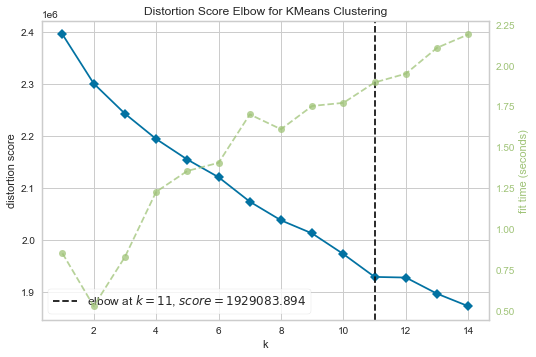

In [230]:
range_tpl = tuple(range(1, 15))
k_means_elbow_viz(X_train, k_range=range_tpl)

For n_clusters = 2 The average silhouette_score is : 0.1364033195794396
For n_clusters = 3 The average silhouette_score is : 0.049059418692825305
For n_clusters = 4 The average silhouette_score is : 0.03672873501206073
For n_clusters = 5 The average silhouette_score is : 0.007751032265284939
For n_clusters = 6 The average silhouette_score is : -0.0038121539708473665
For n_clusters = 7 The average silhouette_score is : 0.005598269848352142
For n_clusters = 8 The average silhouette_score is : 0.003621481028536606
For n_clusters = 9 The average silhouette_score is : -0.0006337897010513021
For n_clusters = 10 The average silhouette_score is : 0.0023109990205915838


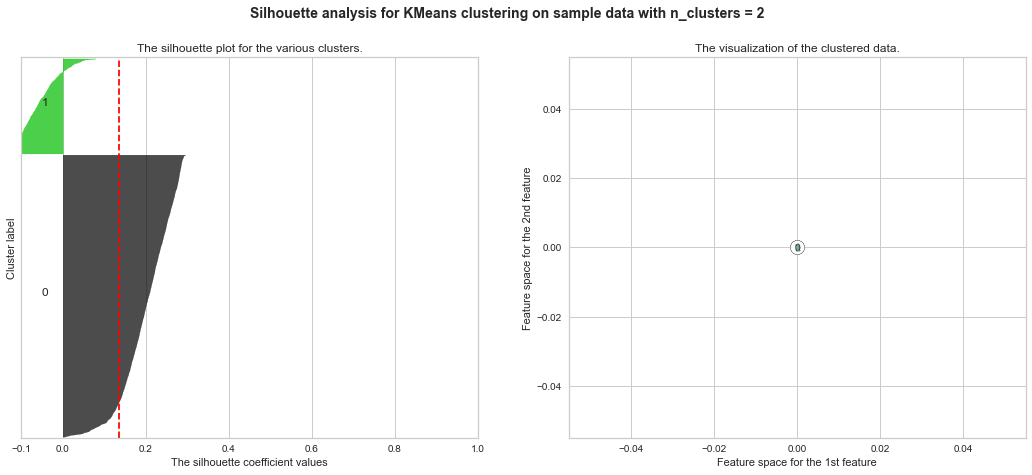

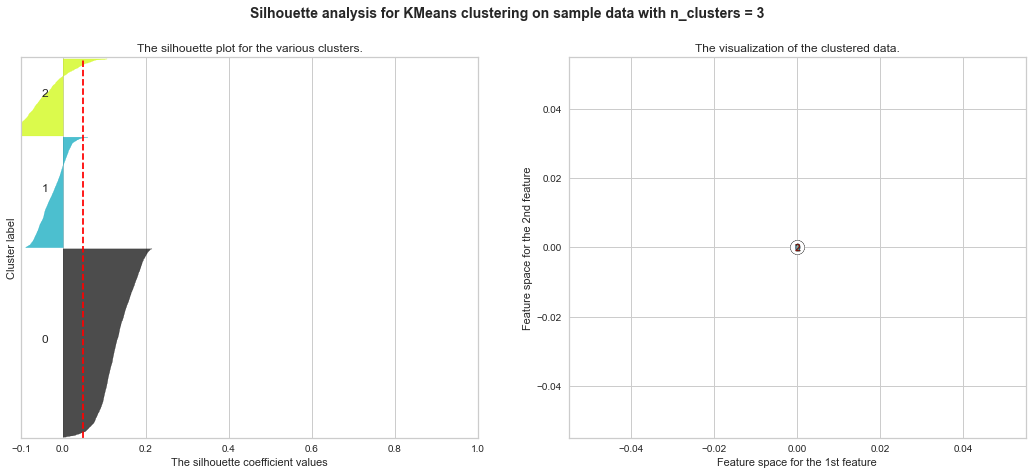

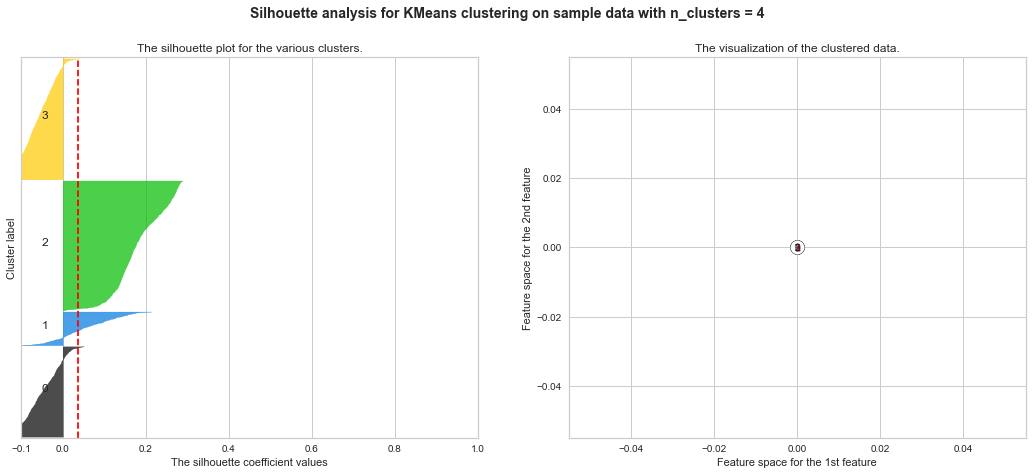

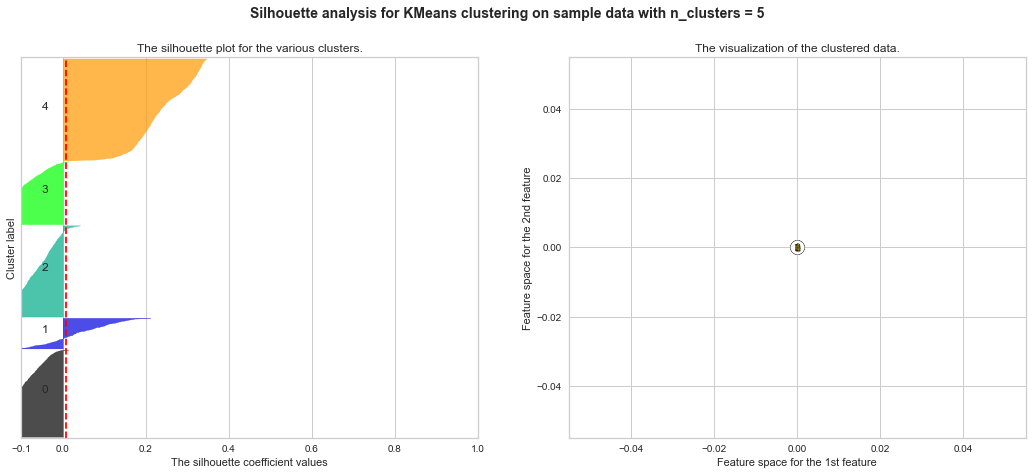

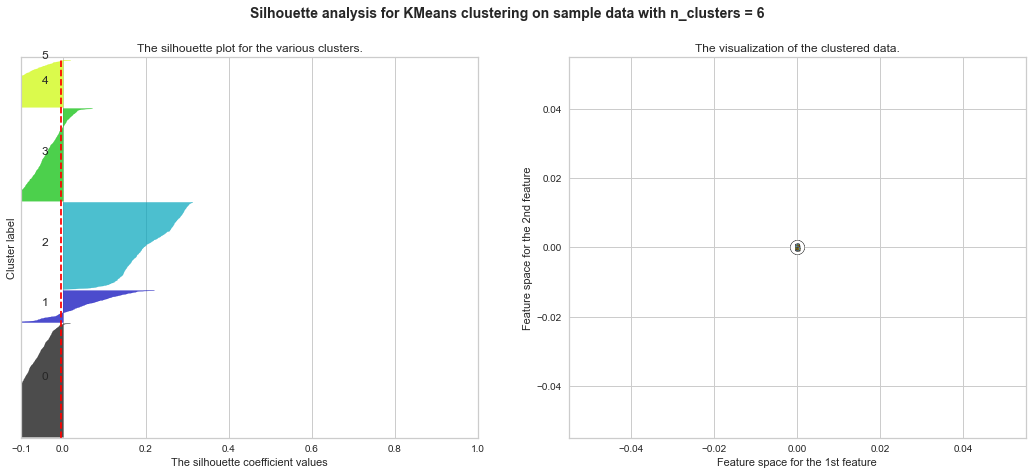

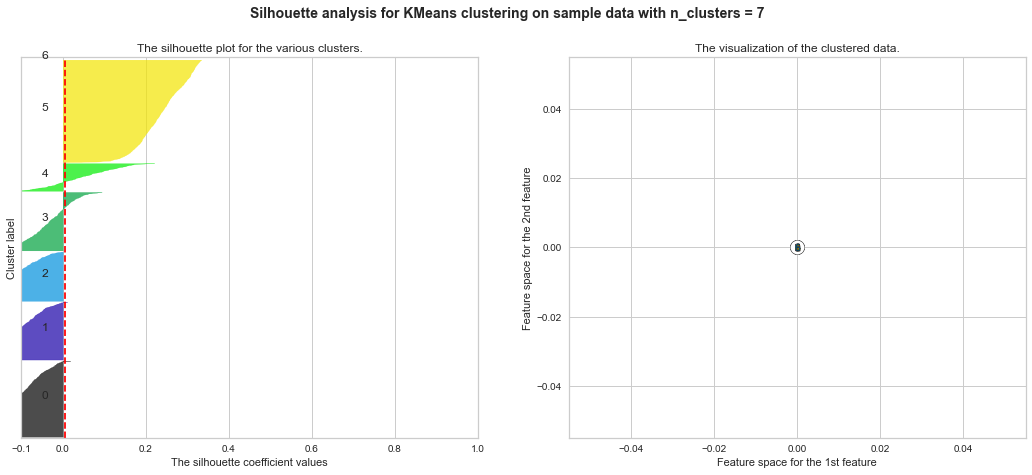

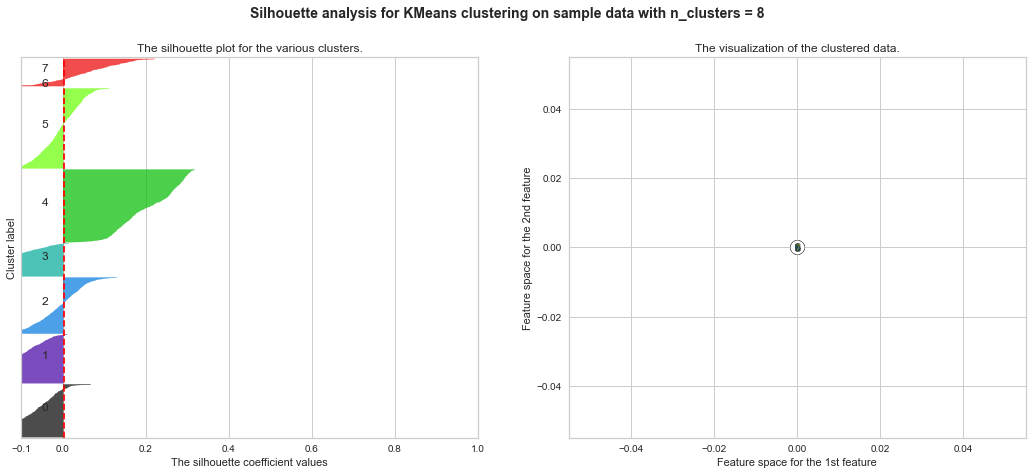

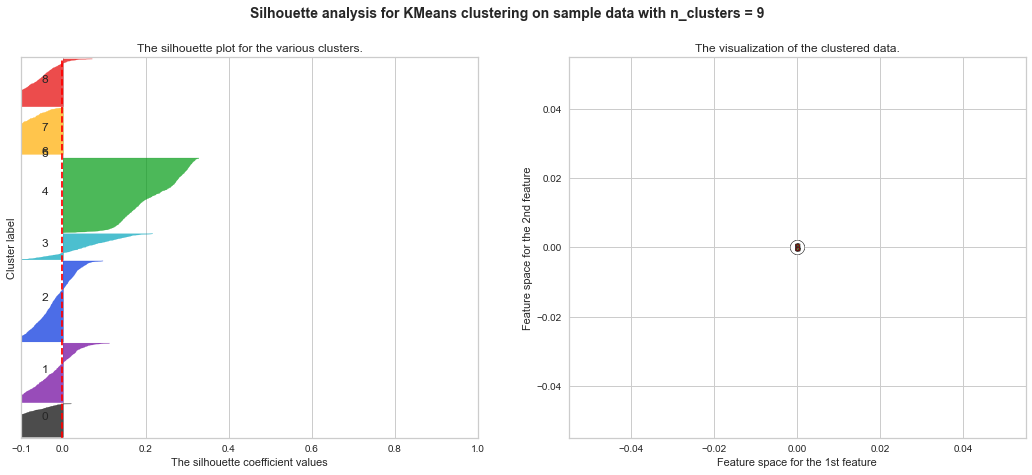

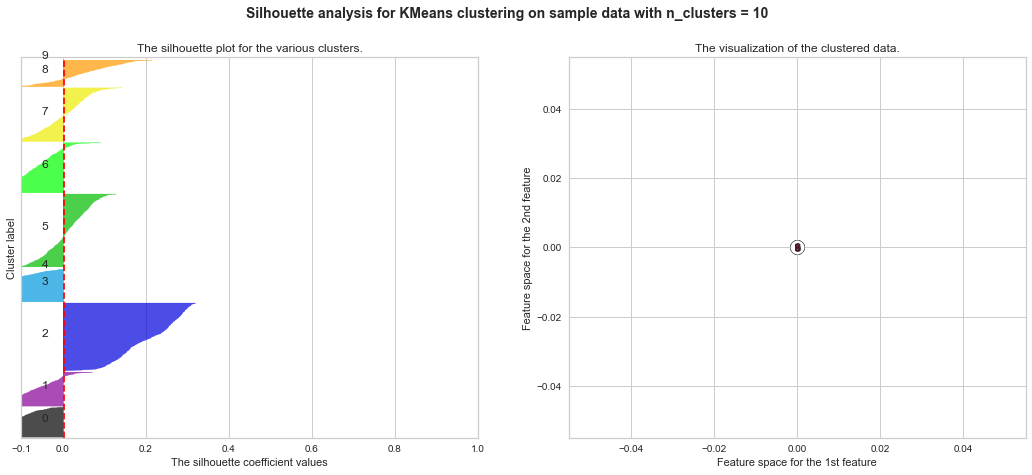

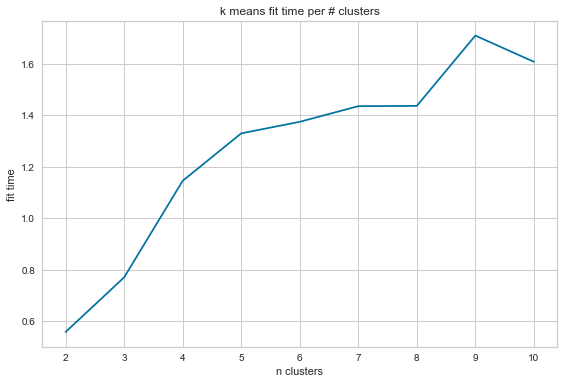

In [199]:
k_means_silhouette(X_train)

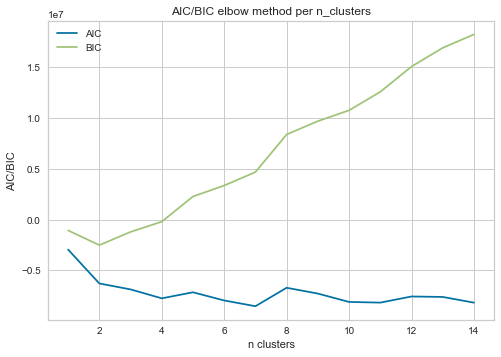

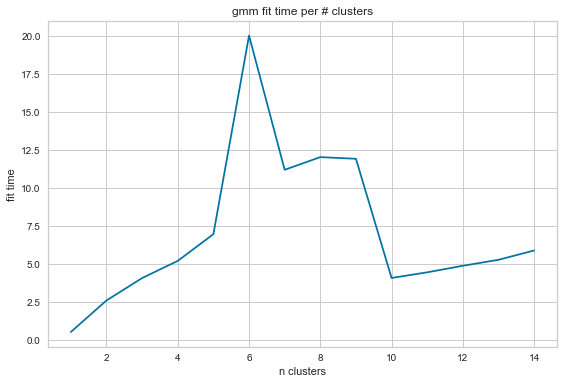

In [231]:
GMM_elbow(X_train, y_train, range_n_clusters=range(1, 15))

In [201]:
kmeans_X_train, kmeans_X_test = k_means_experiment(X_train, X_test, 6)
gmm_X_train, gmm_X_test = k_means_experiment(X_train, X_test, 6)


# PCA

(3360, 784)
(3360, 784)


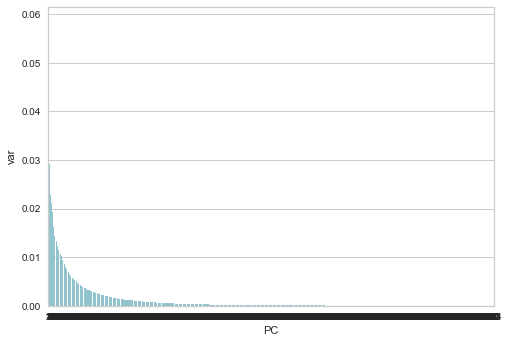

0.05857765449363136
yes
0.04019913474962115
yes
0.036142069781359414
yes
0.029120552690093185
yes
0.026513039532854915
yes
0.022791919651545475
yes
0.02116865379441505
yes
0.020297032350623884
yes
0.019364629608476073
yes
0.01766397658025138
yes
0.016166256884627715
yes
0.014729805336175407
yes
0.01431317368656436
yes
0.013943130168751584
yes
0.0136596366739577
yes
0.013397859499732098
yes
0.012854990998642577
yes
0.012391947449619174
yes
0.011736550283612545
yes
0.011378064213148527
yes
0.011268099877711952
yes
0.010818763319516842
yes
0.010687878961128737
yes
0.010243401131458137
yes
0.01017096355094823
yes
0.009899413245681698
yes
0.009489679066135983
yes
0.009095091782647158
yes
0.008730288368540715
yes
0.0085851019640342
yes
0.008181317219126918
yes
0.008061571954118898
yes
0.007718892947560148
yes
0.007575970985077484
yes
0.007378215140515825
yes
0.007168701977269106
yes
0.006935455750311638
yes
0.006753174506828459
yes
0.00657236407111616
yes
0.00635329106020382
yes
0.0060809931

<Figure size 576x396 with 0 Axes>

In [202]:
pca_X_train, pca_X_test = pca_experiment(X_train, X_test,  y_train, 784, 0.95)

In [203]:
print(pca_X_train.shape)
print(pca_X_test.shape)

(3360, 231)
(840, 231)


# ICA

1
101
201
301
401
501


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


601


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


701


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


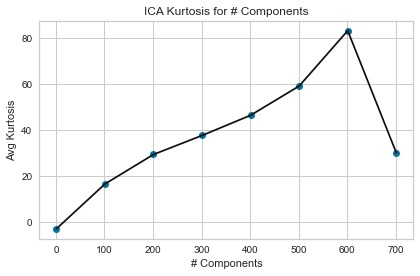

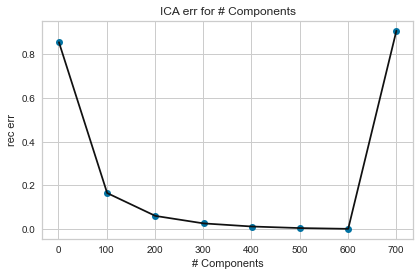

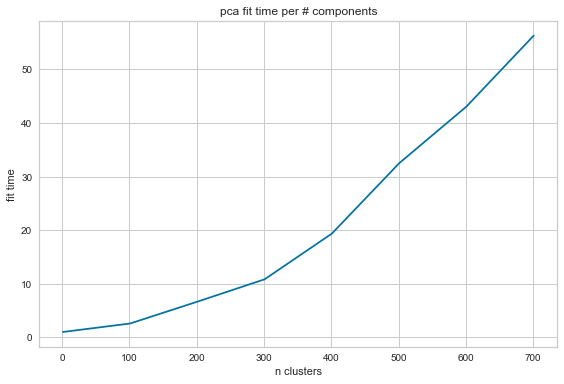

601


In [204]:
best_n_comp_val, best_kurt = analyze_ICA(X_train, 784)
print(best_n_comp_val)


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


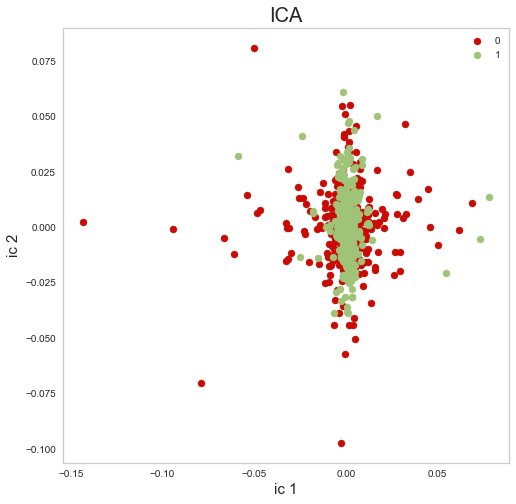

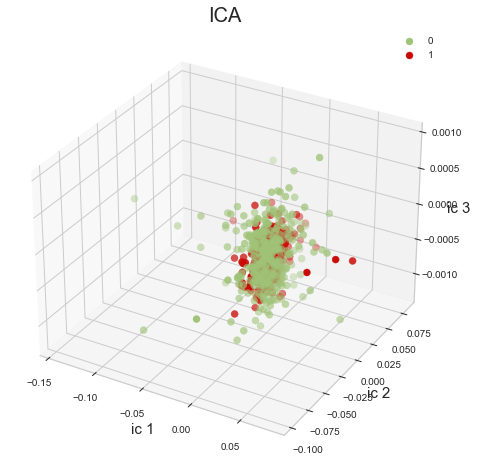

In [205]:
ica_X_train, ica_X_test = ica_experiment(X_train, X_test, y_train, y_test, best_n_comp_val)

# RP

[2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252, 262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382, 392, 402, 412, 422, 432, 442, 452, 462, 472, 482, 492, 502, 512, 522, 532, 542, 552, 562, 572, 582, 592, 602, 612, 622, 632, 642, 652, 662, 672, 682, 692, 702, 712, 722, 732, 742, 752, 762, 772, 782]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3

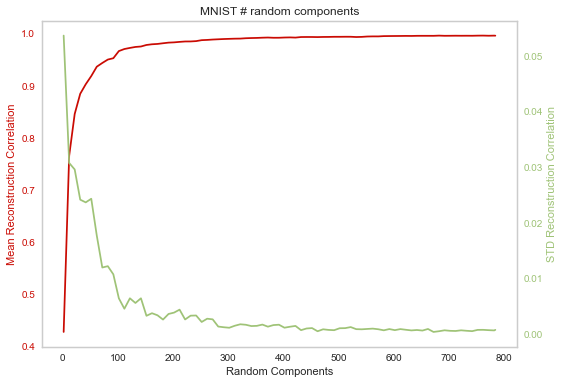

In [241]:
run_SparseRandomProjection(X_train,"mnist")
RP_X_train, RP_X_test = RP_experiment(X_train, X_test, 100)

# RFC

In [207]:
#data_directory = "data/"
#filename = "diabetes.csv"
#df = pd.read_csv(data_directory + filename)

0.00953997826473644
0.008817729362518094
0.008394002262839413
0.007399092243875956
0.007288885746599723
0.0071993248402011266
0.007014883903033898
0.006650183934075362
0.006562036207306665
0.006482947927067208
0.006412238048826702
0.006228314907314413
0.006201767365447942
0.005985358953407135
0.005937204192772437
0.0059168571762005075
0.005890134222284195
0.005870983941765796
0.005850034940103572
0.005836458960582765
0.005785481103778168
0.005744051165924397
0.005709549777487321
0.005709019354775845
0.005657566283330053
0.005610549283504817
0.005607657379669727
0.005603039186666784
0.005566905517927747
0.0055242057610496555
0.0054968327757939535
0.0054698947424096445
0.005316749715377375
0.005301761264381758
0.00525004992813232
0.005183648499094414
0.005141829828685762
0.005119610567562373
0.005116331471400178
0.005106049140240163
0.005086700167137377
0.005009708196951539
0.004949397179482682
0.004937977424220544
0.004937574161596897
0.004907751946110733
0.004880559421288473
0.00487495

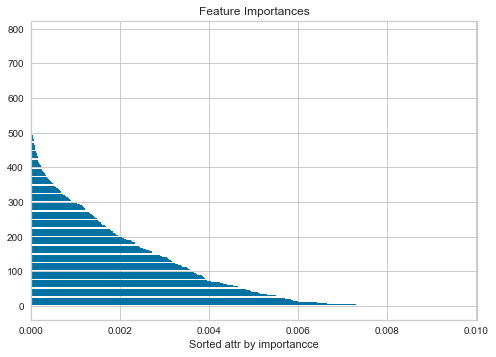

In [208]:
#indices = range(0,len(df.columns[:-1]))
#print(indices)
#RFC_X = RFC_experiment(X_train, y_train, df.columns[:-1], x_indices=indices)
RFC_X_train, RFC_X_test = RFC_experiment(X_train, X_test, y_train)

In [209]:
print(pca_X_train.shape)
print(ica_X_train.shape)
print(RP_X_train.shape)
print(RFC_X_train.shape)

print(pca_X_test.shape)
print(ica_X_test.shape)
print(RP_X_test.shape)
print(RFC_X_test.shape)

(3360, 231)
(3360, 602)
(3360, 600)
(3360, 209)
(840, 231)
(3360, 602)
(840, 600)
(840, 209)


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\users\fuers\anaconda3\envs\ml\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


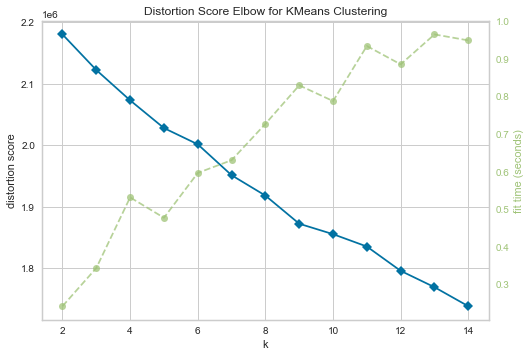

For n_clusters = 2 The average silhouette_score is : 0.14240996292628047
For n_clusters = 3 The average silhouette_score is : 0.05576114523647172
For n_clusters = 4 The average silhouette_score is : 0.03151702427599302
For n_clusters = 5 The average silhouette_score is : 0.020246727800849493
For n_clusters = 6 The average silhouette_score is : 0.029968207648553645
For n_clusters = 7 The average silhouette_score is : 0.007311895675129505
For n_clusters = 8 The average silhouette_score is : 0.008824436658088849
For n_clusters = 9 The average silhouette_score is : 0.00687362207356461
For n_clusters = 10 The average silhouette_score is : 0.0022154637552233227


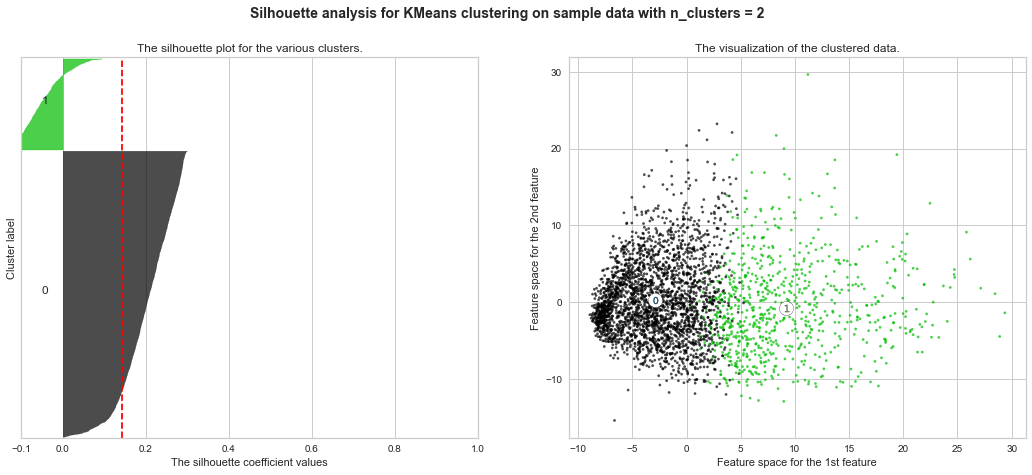

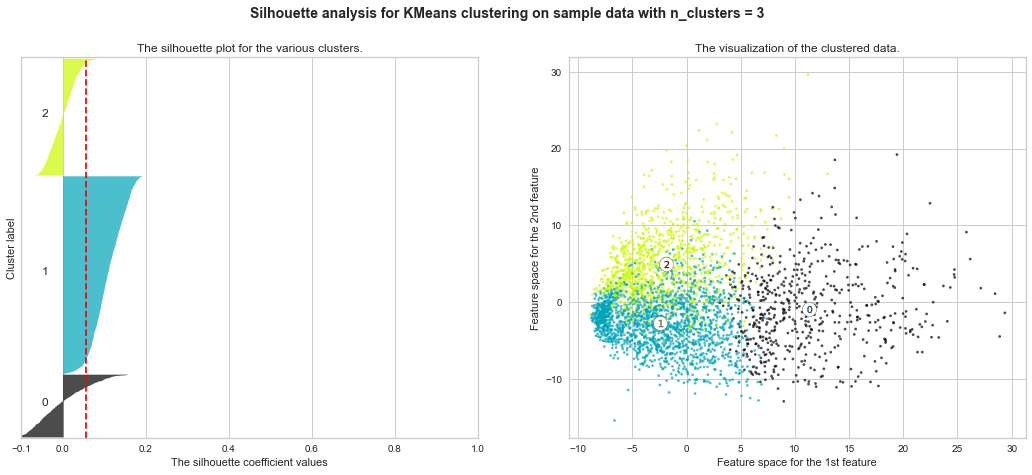

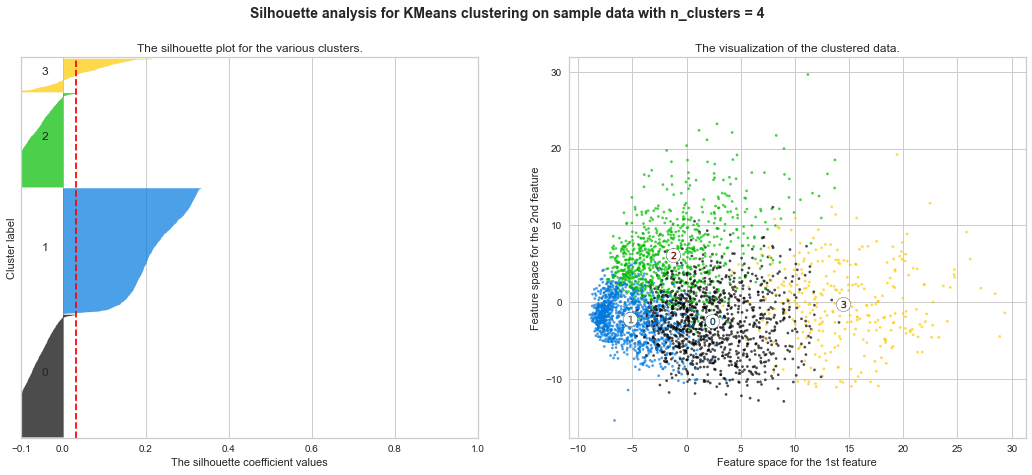

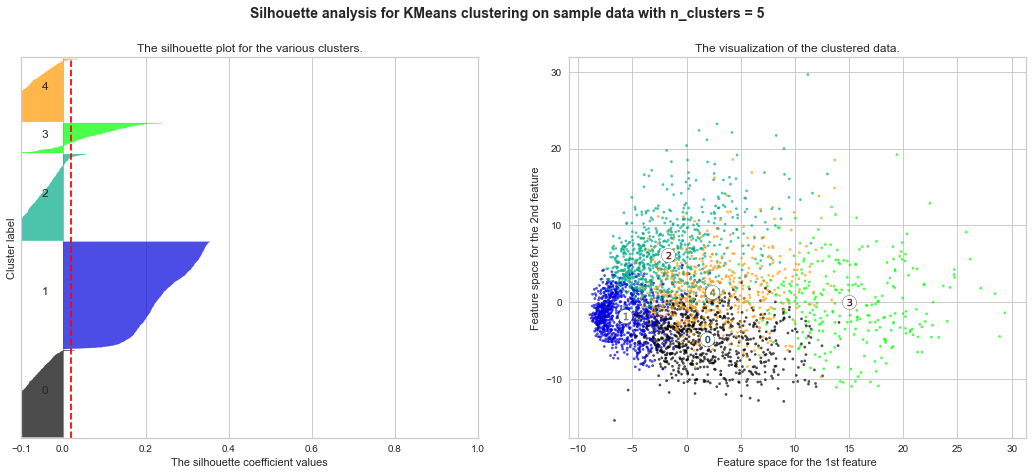

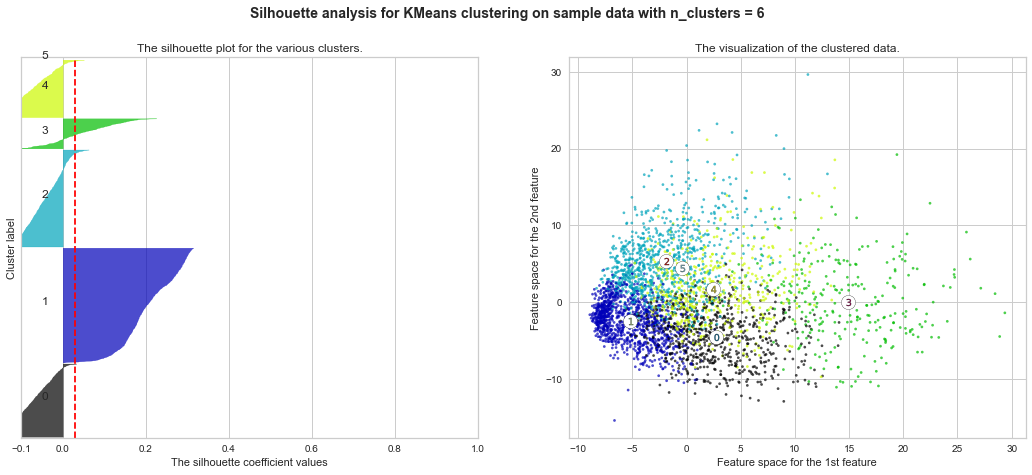

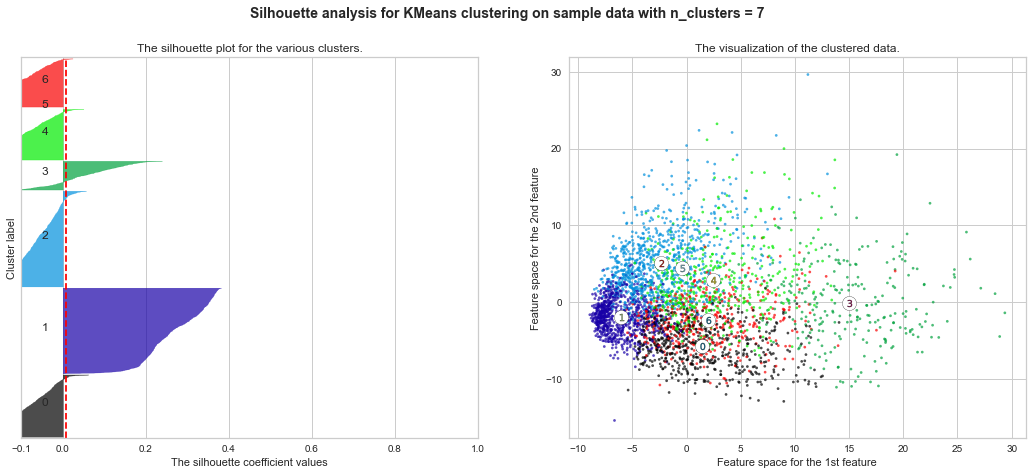

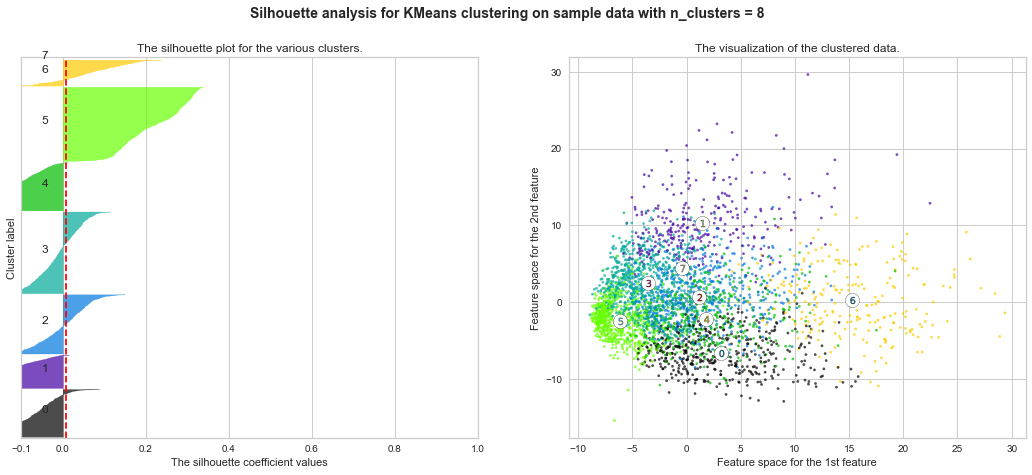

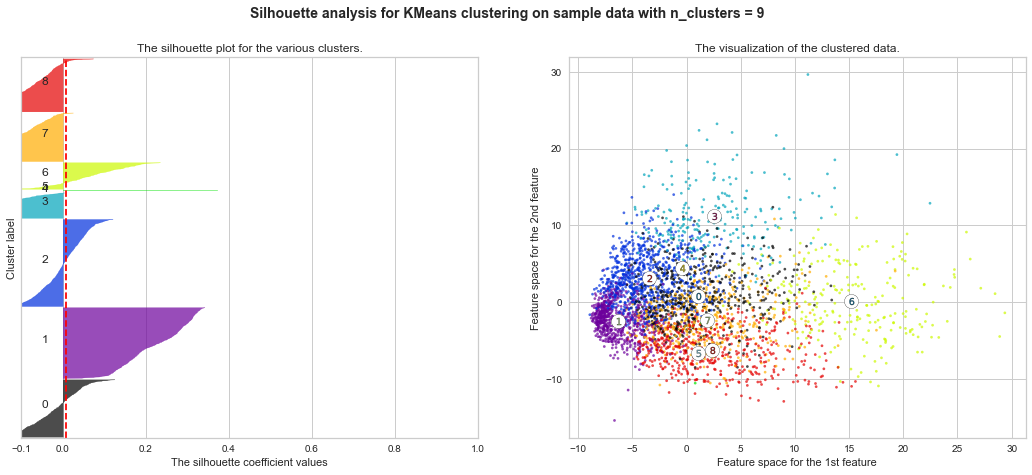

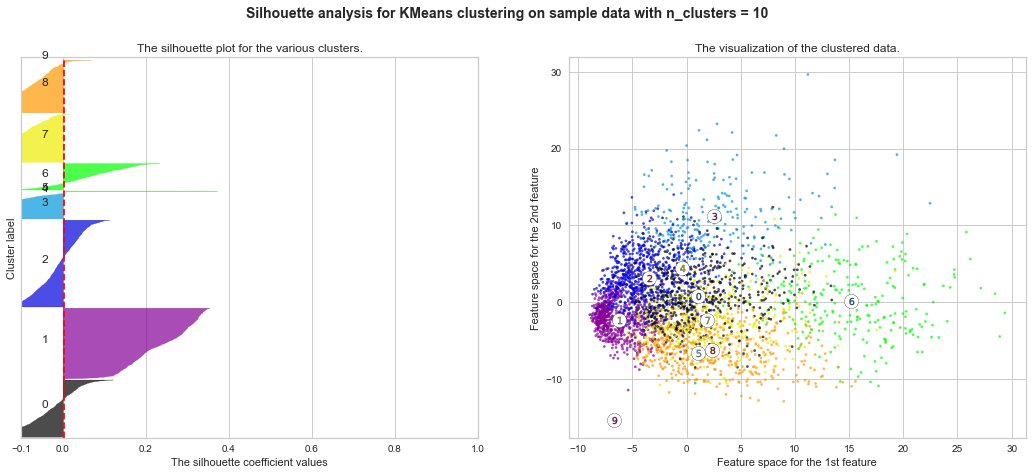

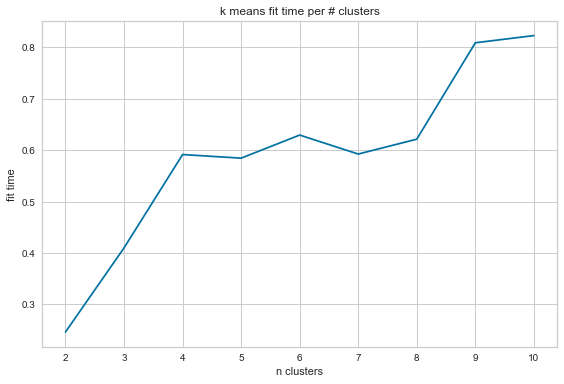

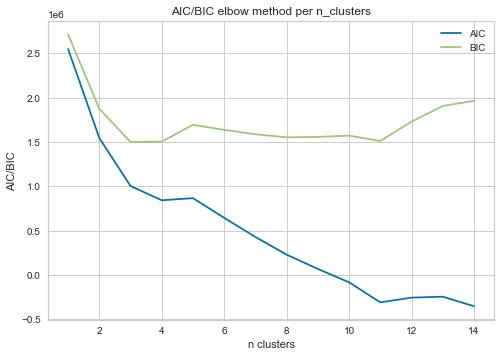

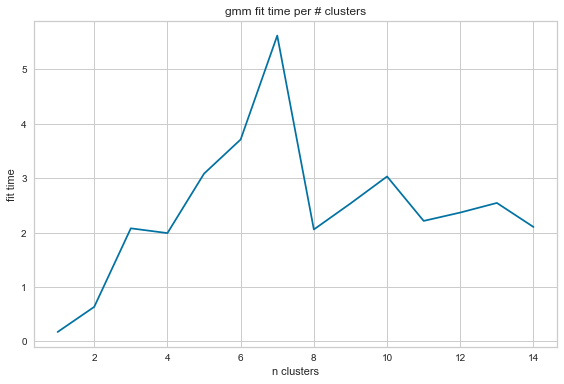

In [219]:
k_means_elbow_viz(pca_X_train)
k_means_silhouette(pca_X_train)
GMM_elbow(pca_X_train, y_train, range_n_clusters=range(1, 15))

(3360, 602)


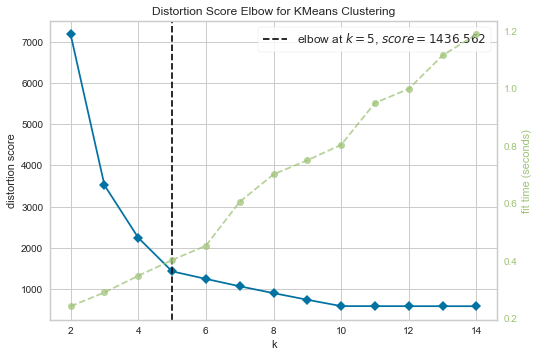

For n_clusters = 2 The average silhouette_score is : 0.618686332068501


TypeError: '(slice(None, None, None), 0)' is an invalid key

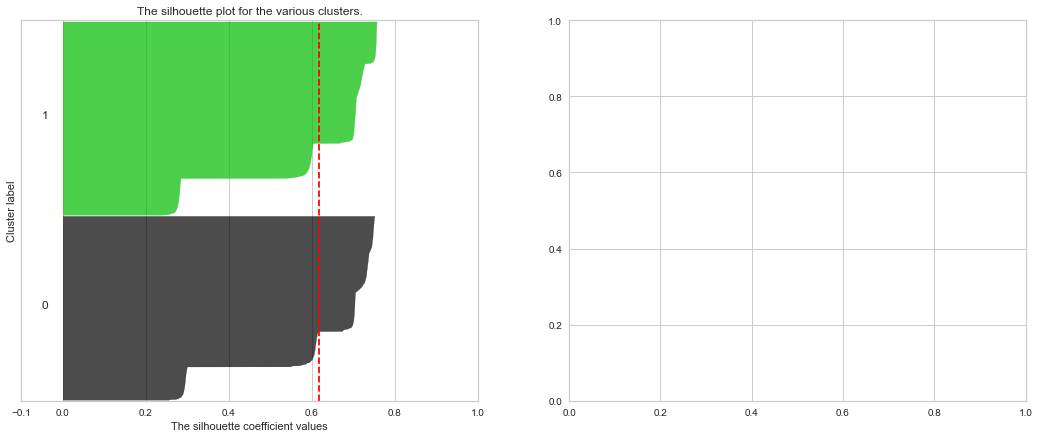

In [245]:
print(ica_X_train.shape)
k_means_elbow_viz(ica_X_train)
k_means_silhouette_iloc(ica_X_train)
GMM_elbow(ica_X_train, y_train, range_n_clusters=range(1, 15))

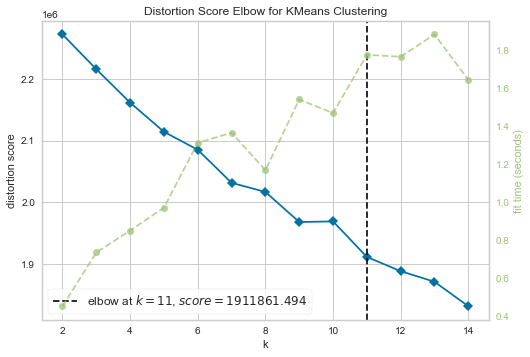

For n_clusters = 2 The average silhouette_score is : 0.13502060174158456
For n_clusters = 3 The average silhouette_score is : 0.04345642158433698
For n_clusters = 4 The average silhouette_score is : 0.03440949161575189
For n_clusters = 5 The average silhouette_score is : 0.02312584952075953
For n_clusters = 6 The average silhouette_score is : 0.01576551511439436
For n_clusters = 7 The average silhouette_score is : 0.021897753493092247
For n_clusters = 8 The average silhouette_score is : 0.013330257074335296
For n_clusters = 9 The average silhouette_score is : 0.0065068264940404685
For n_clusters = 10 The average silhouette_score is : 0.0036154963058634636


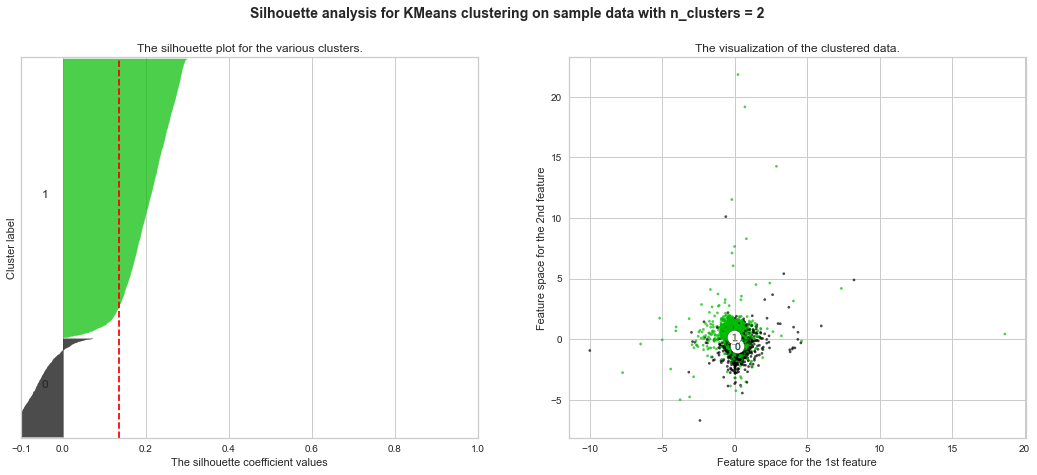

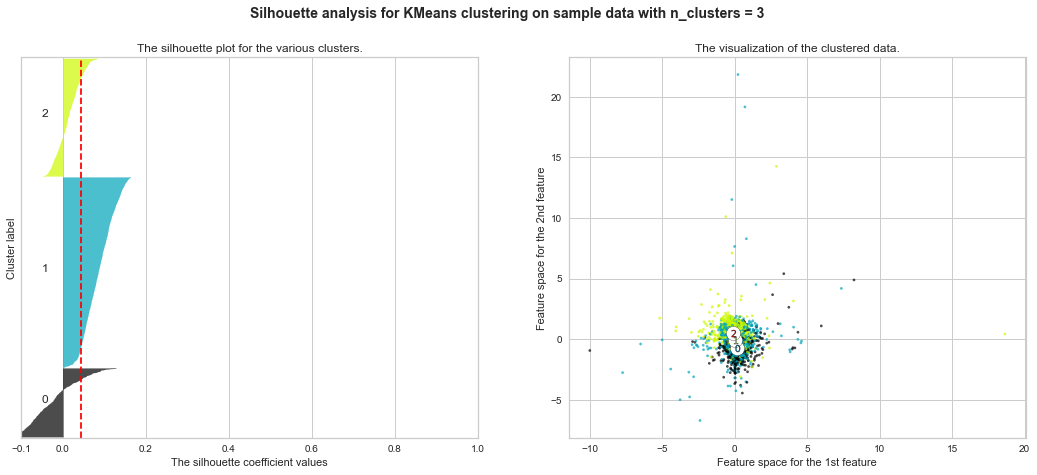

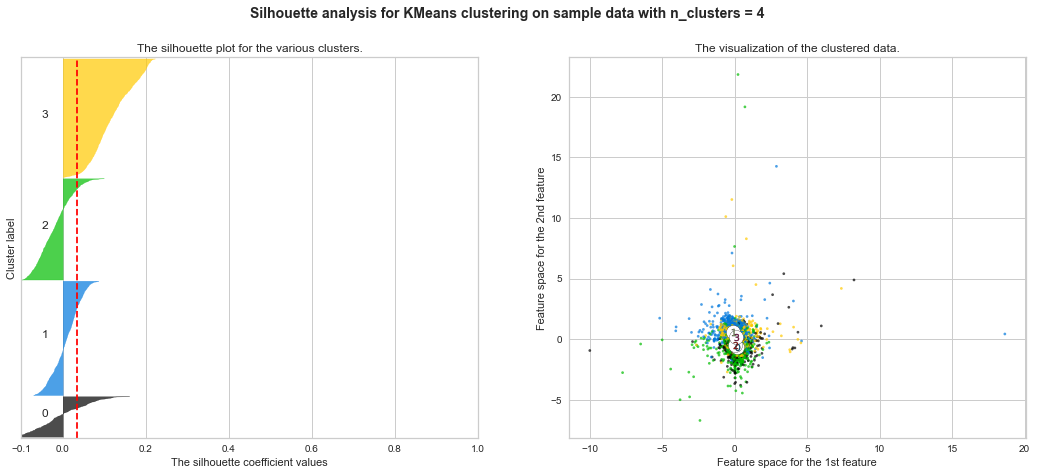

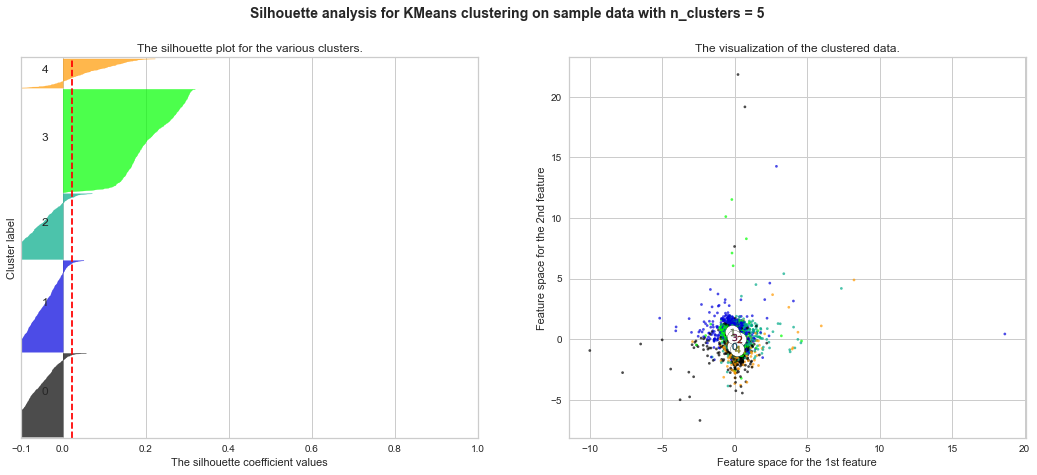

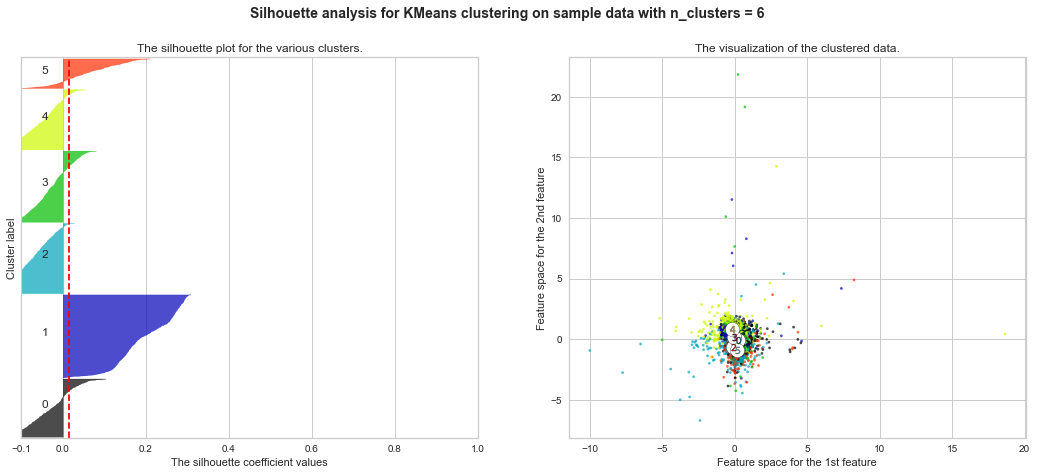

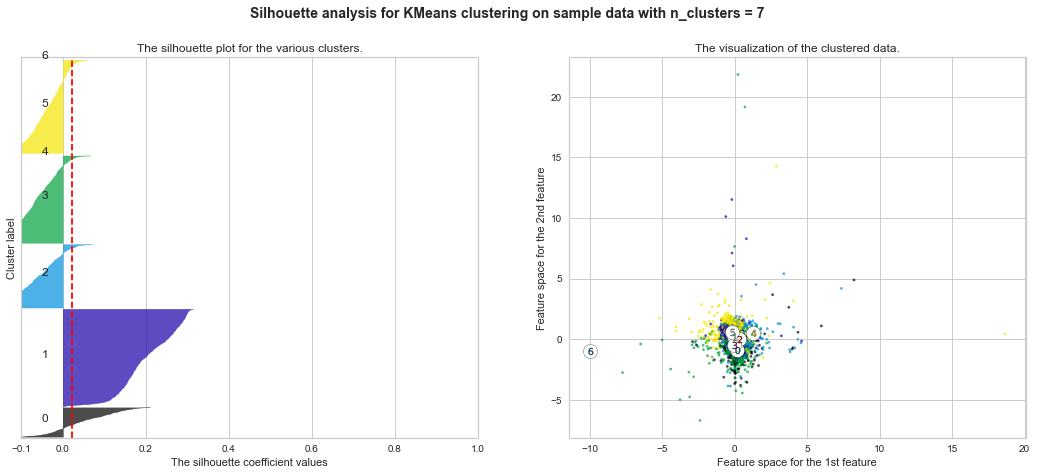

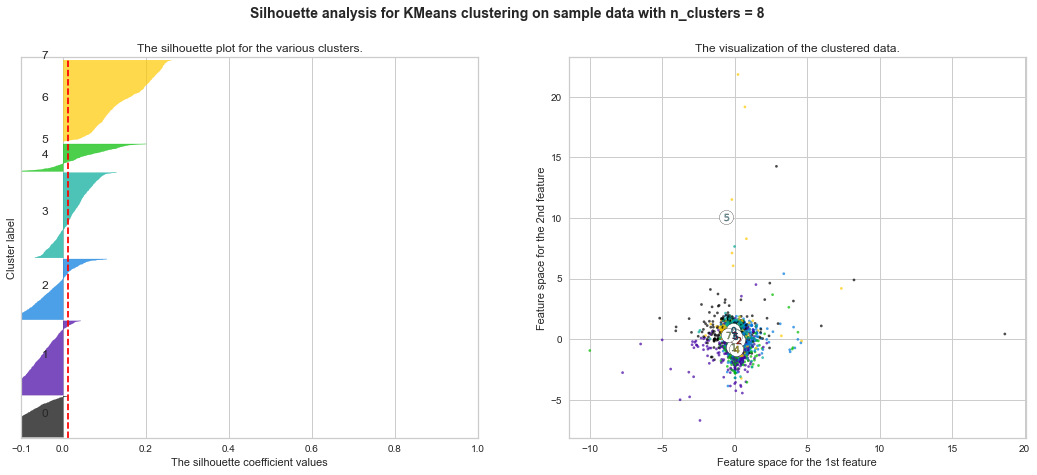

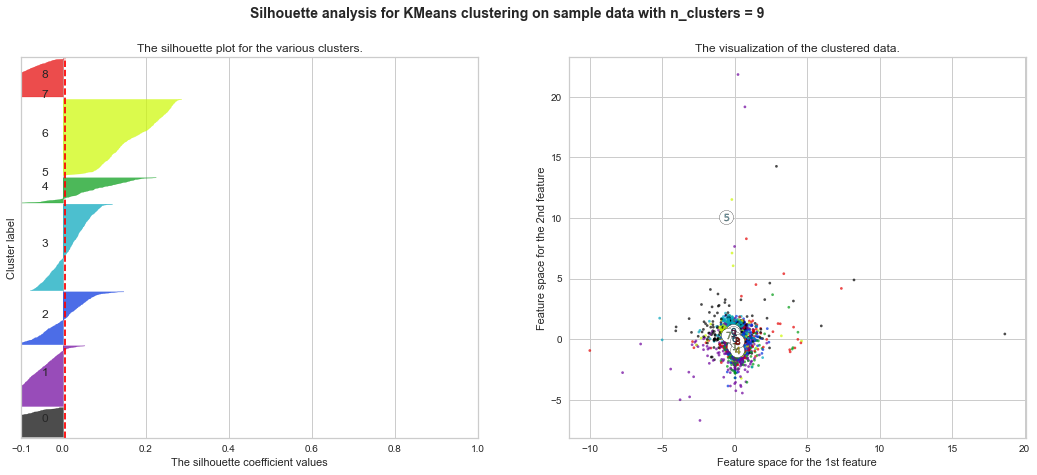

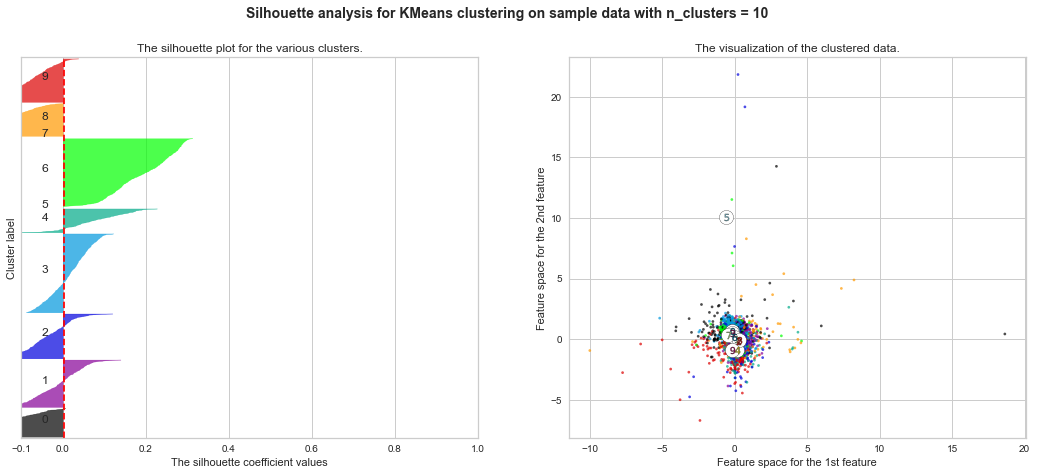

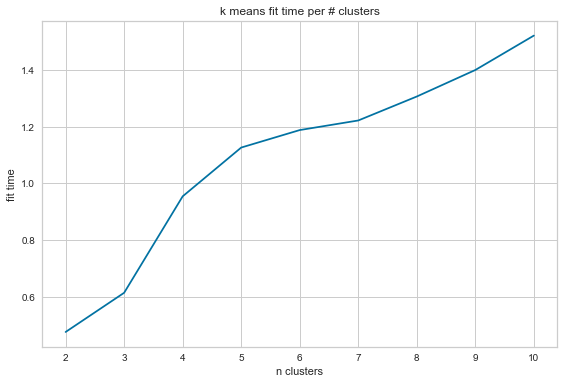

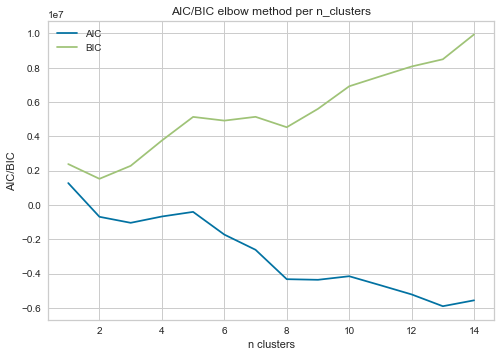

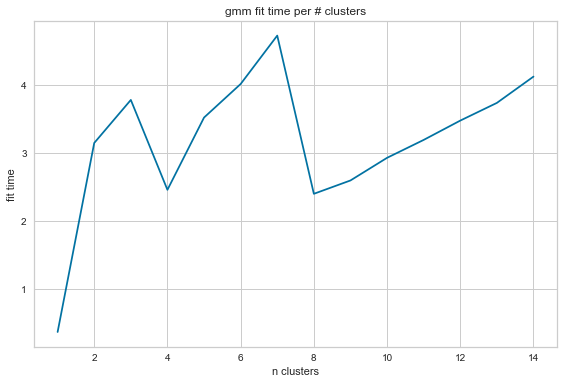

In [220]:
k_means_elbow_viz(RP_X_train)
k_means_silhouette(RP_X_train)
GMM_elbow(RP_X_train, y_train, range_n_clusters=range(1, 15))

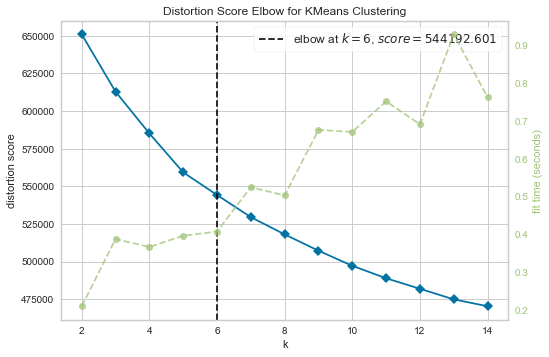

For n_clusters = 2 The average silhouette_score is : 0.08636970789836557
For n_clusters = 3 The average silhouette_score is : 0.06706468462133827
For n_clusters = 4 The average silhouette_score is : 0.07484027356729801
For n_clusters = 5 The average silhouette_score is : 0.08576533008683591
For n_clusters = 6 The average silhouette_score is : 0.08683823277506811
For n_clusters = 7 The average silhouette_score is : 0.08224841167528589
For n_clusters = 8 The average silhouette_score is : 0.07509691829608184
For n_clusters = 9 The average silhouette_score is : 0.08134918312316104
For n_clusters = 10 The average silhouette_score is : 0.08331315887936247


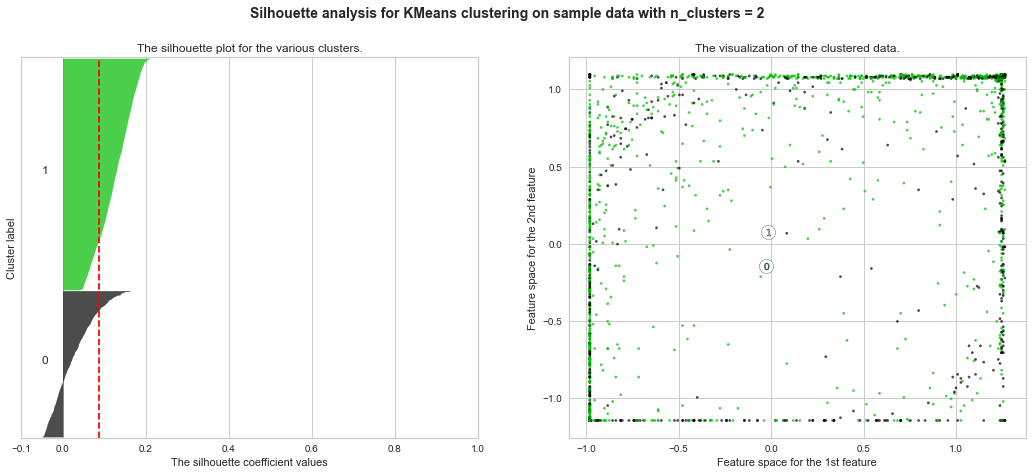

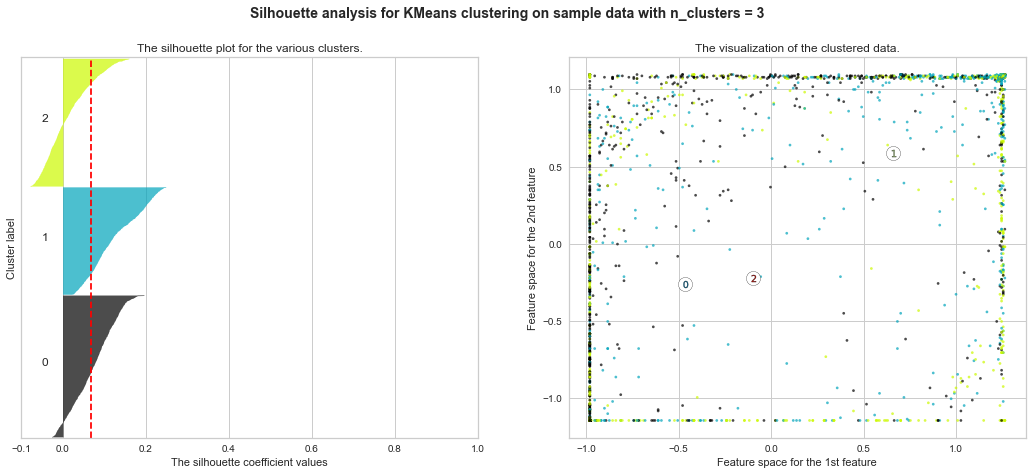

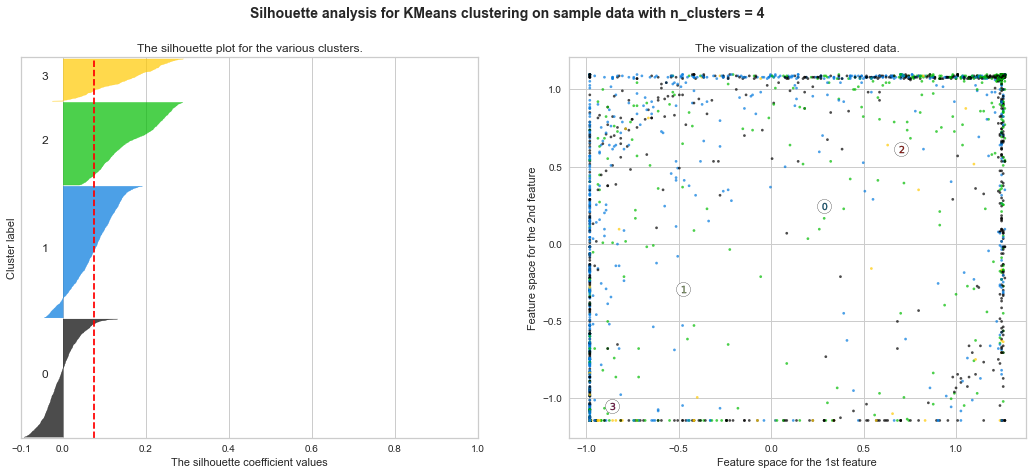

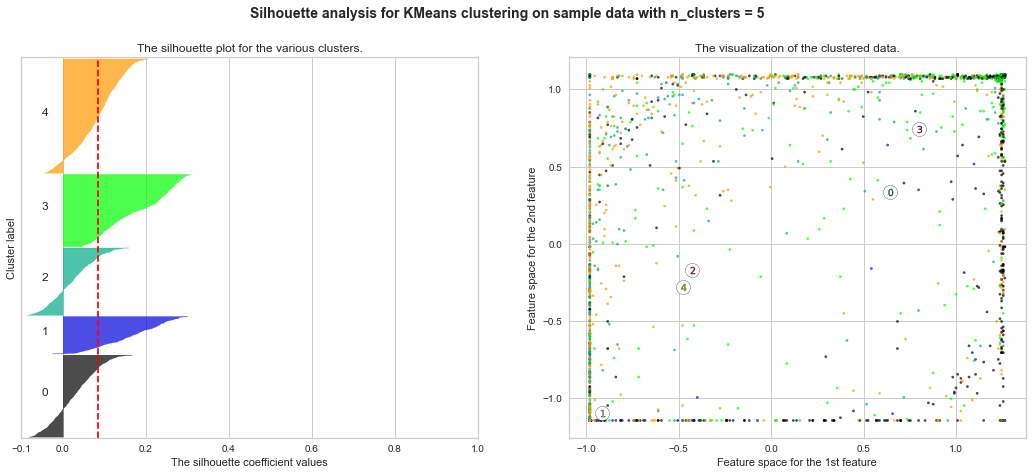

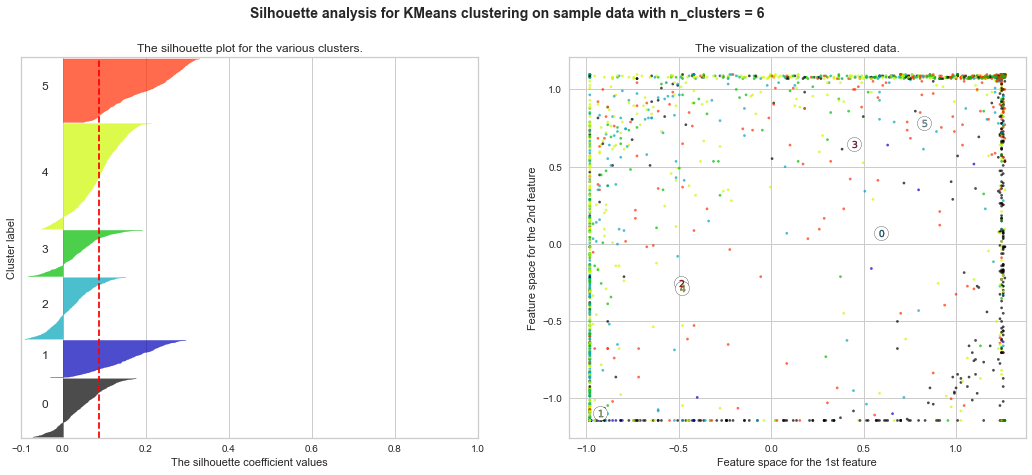

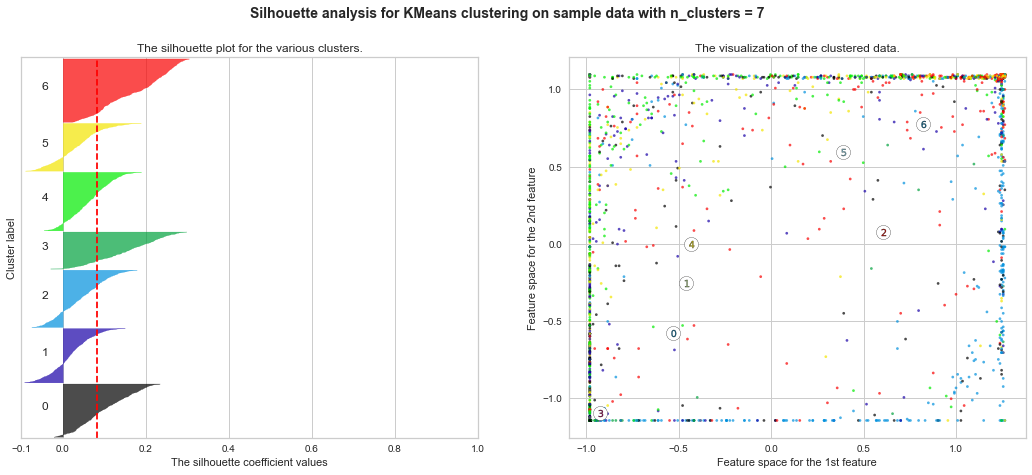

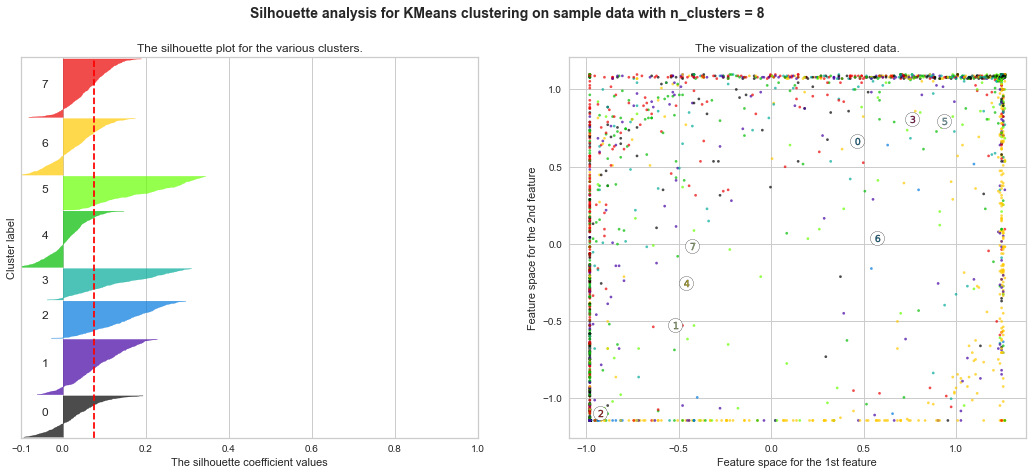

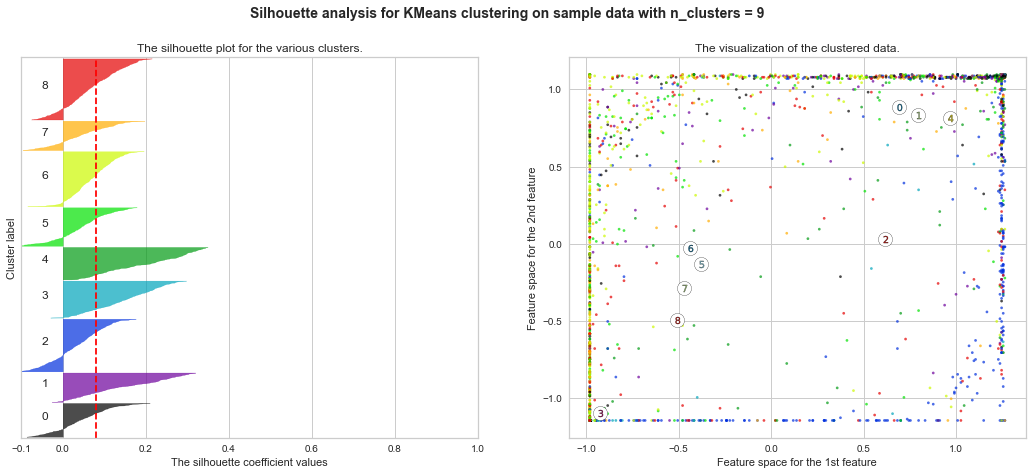

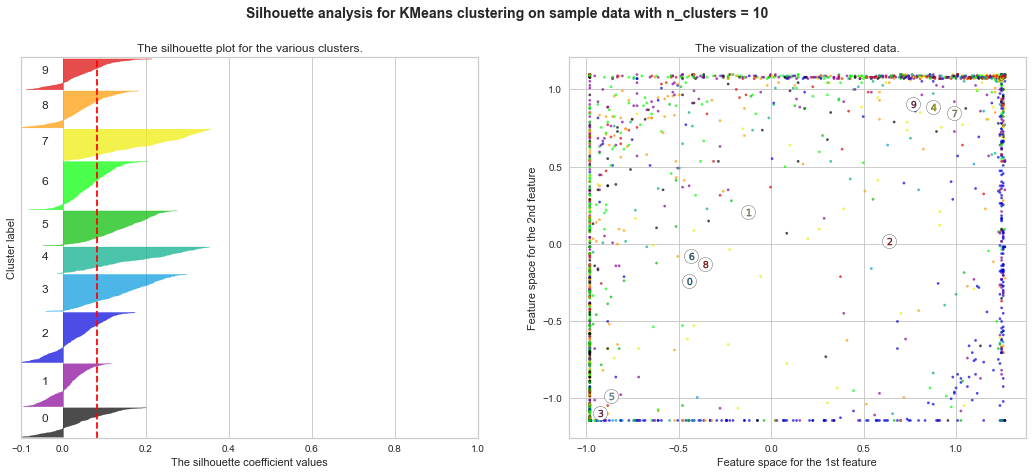

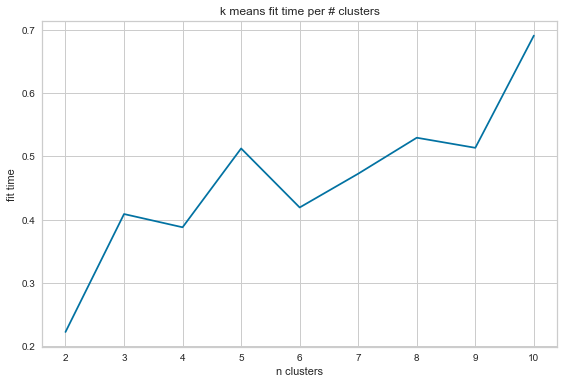

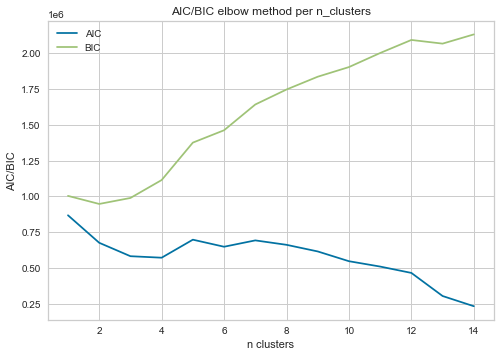

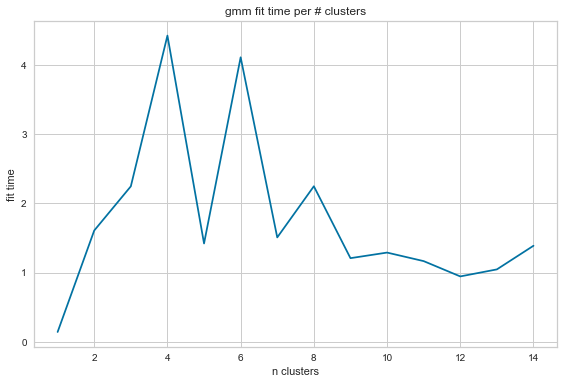

In [221]:
k_means_elbow_viz(RFC_X_train)
k_means_silhouette(RFC_X_train)
GMM_elbow(RFC_X_train, y, range_n_clusters=range(1, 15))

# Neural Network

In [ ]:
print(X_train.shape)
print(pca_X_train.shape)

In [ ]:

run_neural_network(X_train, y_train, X_test, y_test)

In [ ]:
print(pca_X.shape)
run_neural_network(pca_X_train, y_train, pca_X_test, y_test)

In [ ]:
nearest_perfect_square(228)

In [ ]:
from sklearn.neural_network import MLPClassifier
nnet = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=13)
nnet.fit(X_train, y_train)  
#data_train_pred = data_nn.predict(data)
#float(sum(data_train_pred == labels))/float(len(labels))
#data_test_pred = data_nn.predict(data_test) # data_test = x_test
#float(sum(data_test_pred == labels_test))/float(len(labels_test))

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
mlp.fit(X_train, y_train)

In [ ]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

In [ ]:
fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


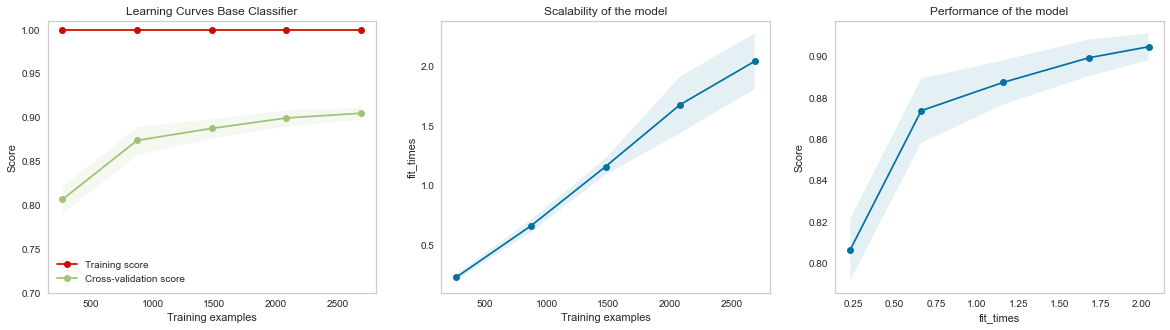

0.9166666666666666
time:  1.6874504089355469


In [252]:
title = r"Learning Curves Base Classifier"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(X_test, y_test))
print("time: ", time_elapsed)

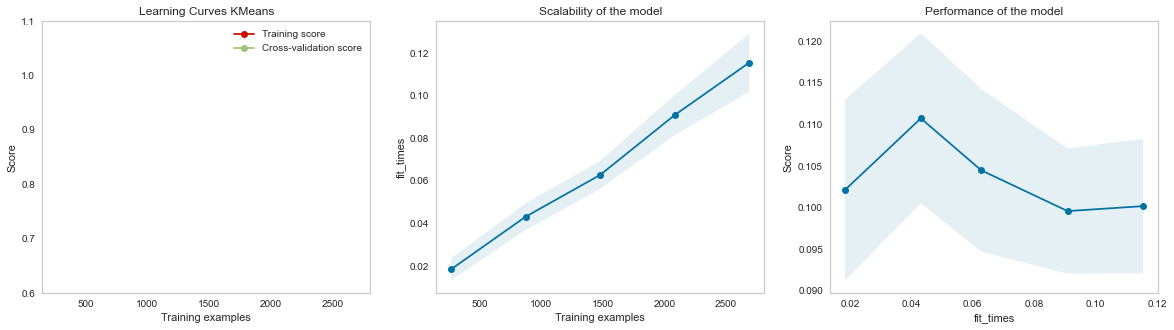

0.10952380952380952
time:  0.12071037292480469


In [253]:
title = r"Learning Curves KMeans"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, kmeans_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()



estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(kmeans_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(kmeans_X_test, y_test))
print("time: ", time_elapsed)

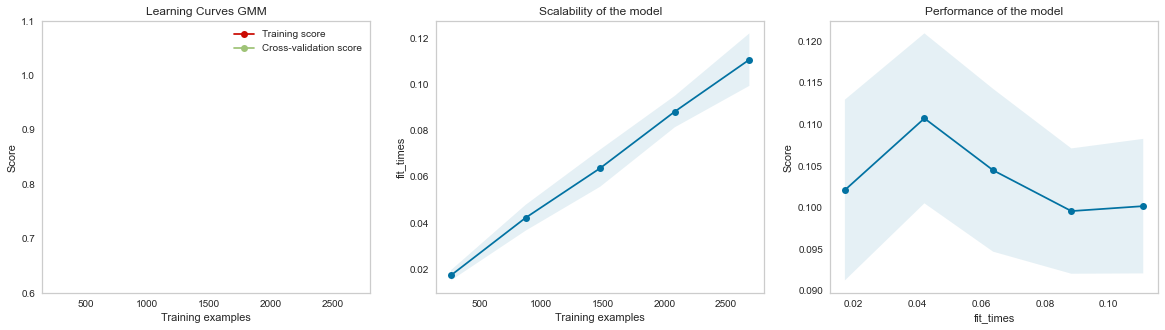

0.10952380952380952
time:  0.12169957160949707


In [248]:
title = r"Learning Curves GMM"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, gmm_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)

time_start = time.time()
estimator.fit(gmm_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(gmm_X_test, y_test))
print("time: ", time_elapsed)

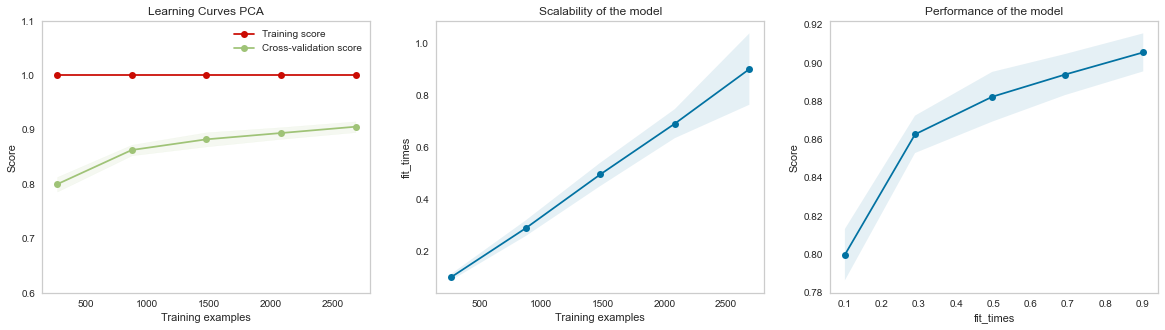

0.9226190476190477
time:  1.2138183116912842


In [249]:
title = r"Learning Curves PCA"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, pca_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(pca_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(pca_X_test, y_test))
print("time: ", time_elapsed)

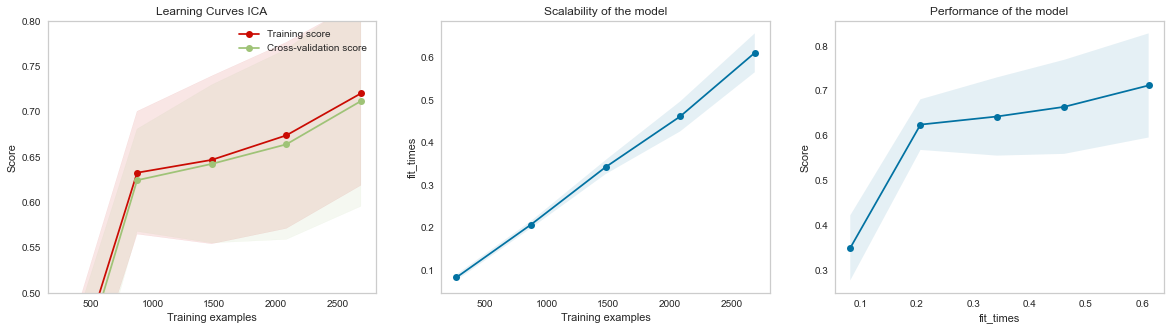

c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ValueError: Found input variables with inconsistent numbers of samples: [840, 3360]

In [254]:
title = r"Learning Curves ICA"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=9, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, ica_X_train, y_train, ylim=(0.5, 0.8),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(ica_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(ica_X_test, y_test))
print("time: ", time_elapsed)

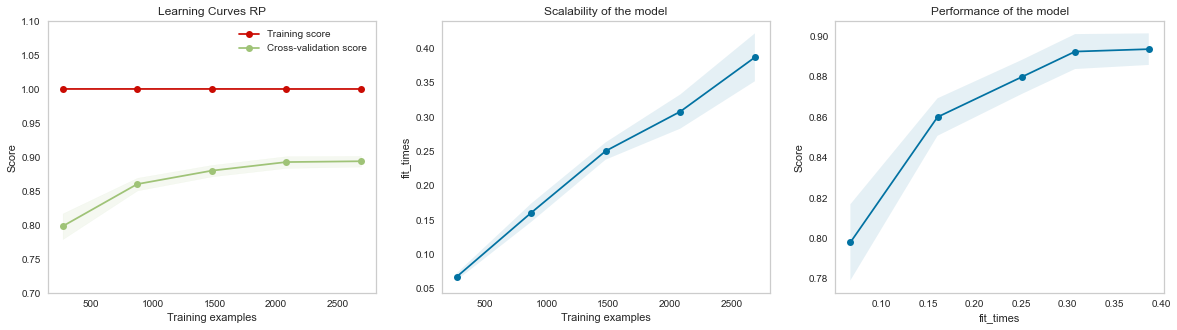

In [228]:
title = r"Learning Curves RP"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, RP_X_train, y_train, ylim=(0.6, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(RP_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(RP_X_test, y_test))
print("time: ", time_elapsed)

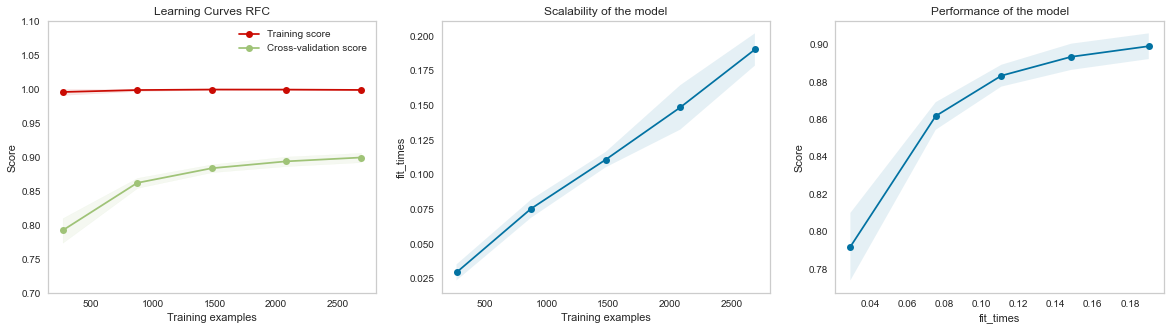

0.9261904761904762
time:  1.2895503044128418


In [255]:
title = r"Learning Curves RFC"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, RFC_X_train, y_train, ylim=(0.7, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=0, random_state=1,
                    learning_rate_init=.1)
time_start = time.time()
estimator.fit(RFC_X_train, y_train)
time_elapsed = time.time() - time_start
print(estimator.score(RFC_X_test, y_test))
print("time: ", time_elapsed)